In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/network-traffic-android-malware/android_traffic.csv


In [2]:
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

## 信息总览

In [3]:
df = pd.read_csv("/kaggle/input/network-traffic-android-malware/android_traffic.csv",sep=";")

In [4]:
df.head()

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,benign
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,NaN,NaN,NaN,7,1,benign
4,AntiVirus,6,0,1,882,0,0,7,6,819,968,NaN,NaN,NaN,7,1,benign


In [5]:
df.type.value_counts()

benign       4704
malicious    3141
Name: type, dtype: int64

一共有17个维度，根据最后一个type，可以看出这是个二分类数据集，查看一下他们的基础信息

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  7845 non-null   object 
 1   tcp_packets           7845 non-null   int64  
 2   dist_port_tcp         7845 non-null   int64  
 3   external_ips          7845 non-null   int64  
 4   vulume_bytes          7845 non-null   int64  
 5   udp_packets           7845 non-null   int64  
 6   tcp_urg_packet        7845 non-null   int64  
 7   source_app_packets    7845 non-null   int64  
 8   remote_app_packets    7845 non-null   int64  
 9   source_app_bytes      7845 non-null   int64  
 10  remote_app_bytes      7845 non-null   int64  
 11  duracion              0 non-null      float64
 12  avg_local_pkt_rate    0 non-null      float64
 13  avg_remote_pkt_rate   0 non-null      float64
 14  source_app_packets.1  7845 non-null   int64  
 15  dns_query_times      

duracion、avg_local_pkt_rate、avg_remote_pkt_rate的值为0，即一直为NaN，对数据分类不会有影响，可以删除，其他数据没有缺失值

In [7]:
df = df.drop(["duracion","avg_local_pkt_rate","avg_remote_pkt_rate"],axis=1)

In [8]:
df.describe(include="O") 

,name,type
count,7845,7845
unique,114,2
top,Reading,benign
freq,774,4704


离散数据有name和type两个，其他都为连续数据

In [9]:
df.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,0.000255,152.911918,194.706310,2.024967e+05,1.692260e+04,152.911918,4.898917
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,0.015966,779.034618,1068.112696,1.401076e+06,8.238182e+04,779.034618,18.900478
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,1.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,7.000000,1.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,30.000000,3.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,98.000000,5.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,1.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,37150.000000,913.000000


查看describe信息，根据25%、75%和max可以推测，数据中存在多个离群点，可以优先考虑将这些离群点删除

In [10]:
#离群点删除
def delete_outlier(df, column_name):
    first_quartile  = df[column_name].describe()["25%"]
    third_quartile  = df[column_name].describe()["75%"]
    iqr = third_quartile - first_quartile
    df = df[(df[column_name] >= (first_quartile - 3 * iqr)) & (df[column_name] <= (third_quartile + 3 * iqr))]
    return df

In [11]:
dispersed = ["name","type"]
cols_name = df.columns.tolist()
for column_name in cols_name:
    if column_name not in dispersed:
        df = delete_outlier(df, column_name)

In [12]:
df.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times
count,4366.000000,4366.0,4366.000000,4366.00000,4366.0,4366.0,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000
mean,18.151855,0.0,1.491296,2802.02382,0.0,0.0,20.449840,17.201557,3127.262712,2969.330050,20.449840,2.212552
std,21.313609,0.0,1.457702,3480.59364,0.0,0.0,22.215401,19.276838,3964.123670,3542.411783,22.215401,1.602600
min,0.000000,0.0,0.000000,0.00000,0.0,0.0,1.000000,0.000000,0.000000,69.000000,1.000000,0.000000
25%,5.000000,0.0,1.000000,444.00000,0.0,0.0,6.000000,3.000000,481.000000,519.000000,6.000000,1.000000
50%,8.000000,0.0,1.000000,1308.00000,0.0,0.0,11.000000,7.000000,1851.000000,1383.000000,11.000000,2.000000
75%,28.000000,0.0,2.000000,4233.25000,0.0,0.0,31.000000,26.000000,4423.250000,4498.000000,31.000000,3.000000
max,108.000000,0.0,9.000000,18520.00000,0.0,0.0,110.000000,148.000000,23597.000000,18886.000000,110.000000,9.000000


处理一下离散变量name

In [13]:
name_counts = df.name.value_counts()
df_name_counts = pd.DataFrame(name_counts)
name_dict = dict(zip(df_name_counts.index.values.tolist(),df_name_counts.name.tolist()))
name_dict

{'Reading': 405,
 'DroidKungFu': 309,
 'Plankton': 265,
 'Opfake': 258,
 'Communication': 202,
 'BaseBridge': 199,
 'HealthAndFitness': 165,
 'FakeInstaller': 163,
 'Photography': 159,
 'Finance': 147,
 'NewsAndMagazines': 145,
 'Kmin': 133,
 'AntiVirus': 131,
 'Education': 128,
 'GinMaster': 125,
 'MediaAndVideo': 120,
 'DailyLife': 120,
 'FakeRun': 110,
 'Input': 103,
 'Productivity': 103,
 'chess': 58,
 'Gappusin': 55,
 'Iconosys': 54,
 'Adrd': 52,
 'SendPay': 48,
 'ExploitLinuxLotoor': 45,
 'Glodream': 45,
 'Tools': 41,
 'Personalization': 40,
 'Imlog': 40,
 'Browser': 39,
 'DroidDream': 35,
 'TravelAndLocal': 31,
 'Social': 29,
 'Shopping': 29,
 'Xsider': 17,
 'FoCobers': 15,
 'SMSreg': 14,
 'Nandrobox': 13,
 'Sport': 12,
 'FakeTimer': 11,
 'SerBG': 10,
 'Nyleaker': 8,
 'Raden': 8,
 'Zsone': 7,
 'Yzhc': 6,
 'TrojanSMS.Hippo': 6,
 'DroidSheep': 5,
 'TrojanSMS.Denofow': 5,
 'Gonca': 5,
 'FakeDoc': 5,
 'Aks': 5,
 'Steek': 5,
 'RootSmart': 5,
 'Sakezon': 4,
 'Gapev': 4,
 'Spyset': 4,


数量较多，可以将数量较少的name合并为一个

In [14]:
# name_indexs = df.name.values.tolist()
value_name = []
for key,value in name_dict.items():
    if value <= 50:
        value_name.append(key)
df.loc[df["name"].isin(value_name),"name"] = "Others" 
name_indexs = list(set(df.name.values.tolist()))
for i in range(len(name_indexs)):
    df.loc[df["name"] == name_indexs[i], "name"] = i

将type映射为0和1的二分类

In [15]:
df["type"] = df["type"].map({"malicious":1,"benign":0})

In [16]:
df.type.value_counts()

0    2207
1    2159
Name: type, dtype: int64

再次查看一下df的基础信息

In [17]:
df.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
count,4366.000000,4366.0,4366.000000,4366.00000,4366.0,4366.0,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000
mean,18.151855,0.0,1.491296,2802.02382,0.0,0.0,20.449840,17.201557,3127.262712,2969.330050,20.449840,2.212552,0.494503
std,21.313609,0.0,1.457702,3480.59364,0.0,0.0,22.215401,19.276838,3964.123670,3542.411783,22.215401,1.602600,0.500027
min,0.000000,0.0,0.000000,0.00000,0.0,0.0,1.000000,0.000000,0.000000,69.000000,1.000000,0.000000,0.000000
25%,5.000000,0.0,1.000000,444.00000,0.0,0.0,6.000000,3.000000,481.000000,519.000000,6.000000,1.000000,0.000000
50%,8.000000,0.0,1.000000,1308.00000,0.0,0.0,11.000000,7.000000,1851.000000,1383.000000,11.000000,2.000000,0.000000
75%,28.000000,0.0,2.000000,4233.25000,0.0,0.0,31.000000,26.000000,4423.250000,4498.000000,31.000000,3.000000,1.000000
max,108.000000,0.0,9.000000,18520.00000,0.0,0.0,110.000000,148.000000,23597.000000,18886.000000,110.000000,9.000000,1.000000


可以发现删除离群点后，udp_packets、tcp_urg_packet、dist_port_tcp三个特征数据已经归零，即该数据基本为0，对结果影响基本没有影响，可以删除该三个特征

In [18]:
df = df.drop(["udp_packets","tcp_urg_packet","dist_port_tcp"],axis=1)

In [19]:
df.head()

,name,tcp_packets,external_ips,vulume_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
3,19,6,1,889,7,6,819,975,7,1,0
4,19,6,1,882,7,6,819,968,7,1,0
6,19,6,1,889,7,6,819,975,7,1,0
7,19,6,1,1154,7,6,593,1228,7,1,0
8,19,6,1,888,7,6,819,974,7,1,0


此时观察剩余的特征，对于app_packets、app_bytes，可以分别构造remote和source的平均savg_app_bytes特征；此外，source_app_packets.1和source_app_packets数据差异不大，可以只用其中一个

In [20]:
df["avg_source_app_bytes"] = df["source_app_bytes"]/df["source_app_packets"]
df = df.round({"avg_source_app_bytes":2})
df["avg_remote_app_bytes"] = df["remote_app_bytes"]/df["remote_app_packets"]
df = df.round({"avg_remote_app_bytes":2})
df = df.drop(["source_app_packets","remote_app_packets","source_app_bytes","remote_app_bytes","source_app_packets.1"],axis=1)

In [21]:
df.describe()

,tcp_packets,external_ips,vulume_bytes,dns_query_times,type,avg_source_app_bytes,avg_remote_app_bytes
count,4366.000000,4366.000000,4366.00000,4366.000000,4366.000000,4366.000000,4366.00
mean,18.151855,1.491296,2802.02382,2.212552,0.494503,201.290811,inf
std,21.313609,1.457702,3480.59364,1.602600,0.500027,741.303639,NaN
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.43
25%,5.000000,1.000000,444.00000,1.000000,0.000000,109.740000,104.52
50%,8.000000,1.000000,1308.00000,2.000000,0.000000,138.880000,155.46
75%,28.000000,2.000000,4233.25000,3.000000,1.000000,171.332500,197.43
max,108.000000,9.000000,18520.00000,9.000000,1.000000,23597.000000,inf


此时基本为处理过的序数特征，对其进行离散化

In [22]:
df["vulume_bytes_band"] = pd.cut(df["vulume_bytes"],5) # 等宽切分
df[["vulume_bytes_band","type"]].groupby(["vulume_bytes_band"],as_index=False).mean().sort_values(by="vulume_bytes_band",ascending=False)

,vulume_bytes_band,type
4,"(14816.0, 18520.0]",0.393443
3,"(11112.0, 14816.0]",0.575472
2,"(7408.0, 11112.0]",0.564972
1,"(3704.0, 7408.0]",0.472103
0,"(-18.52, 3704.0]",0.490782


In [23]:
df.loc[df["vulume_bytes"] <= 3704.0, "vulume_bytes"] = 0
df.loc[(df["vulume_bytes"] > 3704.0) & (df["vulume_bytes"] <= 7408.0), "vulume_bytes"] = 1
df.loc[(df["vulume_bytes"] > 7408.0) & (df["vulume_bytes"] <= 11112.0), "vulume_bytes"] = 2
df.loc[(df["vulume_bytes"] > 11112.0) & (df["vulume_bytes"] <= 14816.0), "vulume_bytes"] = 3
df.loc[(df["vulume_bytes"] > 14816.0) & (df["vulume_bytes"] <=  18520.0), "vulume_bytes"] = 4


In [24]:
df = df.drop(["vulume_bytes_band"],axis=1)

In [25]:
df.describe()

,tcp_packets,external_ips,vulume_bytes,dns_query_times,type,avg_source_app_bytes,avg_remote_app_bytes
count,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.00
mean,18.151855,1.491296,0.450985,2.212552,0.494503,201.290811,inf
std,21.313609,1.457702,0.850444,1.602600,0.500027,741.303639,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.43
25%,5.000000,1.000000,0.000000,1.000000,0.000000,109.740000,104.52
50%,8.000000,1.000000,0.000000,2.000000,0.000000,138.880000,155.46
75%,28.000000,2.000000,1.000000,3.000000,1.000000,171.332500,197.43
max,108.000000,9.000000,4.000000,9.000000,1.000000,23597.000000,inf


In [26]:
df[["avg_source_app_bytes", "type"]].groupby(['avg_source_app_bytes'], as_index=False).mean().sort_values(by='type', ascending=False)

,avg_source_app_bytes,type
2092,23597.00,1.0
525,106.68,1.0
527,106.80,1.0
528,106.83,1.0
1243,144.71,1.0
...,...,...
1264,145.97,0.0
515,106.24,0.0
517,106.32,0.0
518,106.33,0.0


In [27]:
df["avg_source_app_bytes_band"] = pd.qcut(df["avg_source_app_bytes"],5)
df[["avg_source_app_bytes_band","type"]].groupby(["avg_source_app_bytes_band"],as_index=False).mean().sort_values(by="avg_source_app_bytes_band",ascending=False)

,avg_source_app_bytes_band,type
4,"(204.95, 23597.0]",0.294387
3,"(145.1, 204.95]",0.572738
2,"(128.5, 145.1]",0.683237
1,"(101.73, 128.5]",0.364359
0,"(-0.001, 101.73]",0.560641


In [28]:
df.loc[df["avg_source_app_bytes"] <= 101.73, "avg_source_app_bytes"] = 0
df.loc[(df["avg_source_app_bytes"] > 101.73) & (df["avg_source_app_bytes"] <= 128.5), "avg_source_app_bytes"] = 1
df.loc[(df["avg_source_app_bytes"] > 128.5) & (df["avg_source_app_bytes"] <= 145.1), "avg_source_app_bytes"] = 2
df.loc[(df["avg_source_app_bytes"] > 145.1) & (df["avg_source_app_bytes"] <=  204.95), "avg_source_app_bytes"] = 3
df.loc[(df["avg_source_app_bytes"] >  204.95) & (df["avg_source_app_bytes"] <= 23597.0), "avg_source_app_bytes"] = 4

In [29]:
df = df.drop(["avg_source_app_bytes_band"],axis=1)

In [30]:
df.describe()

,tcp_packets,external_ips,vulume_bytes,dns_query_times,type,avg_source_app_bytes,avg_remote_app_bytes
count,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.00
mean,18.151855,1.491296,0.450985,2.212552,0.494503,1.997710,inf
std,21.313609,1.457702,0.850444,1.602600,0.500027,1.415183,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.43
25%,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,104.52
50%,8.000000,1.000000,0.000000,2.000000,0.000000,2.000000,155.46
75%,28.000000,2.000000,1.000000,3.000000,1.000000,3.000000,197.43
max,108.000000,9.000000,4.000000,9.000000,1.000000,4.000000,inf


In [31]:
df["avg_remote_app_bytes_band"] = pd.qcut(df["avg_remote_app_bytes"],5)
df[["avg_remote_app_bytes_band","type"]].groupby(["avg_remote_app_bytes_band"],as_index=False).mean().sort_values(by="avg_remote_app_bytes_band",ascending=False)

,avg_remote_app_bytes_band,type
4,"(197.57, inf]",0.540445
3,"(169.5, 197.57]",0.347534
2,"(141.46, 169.5]",0.381881
1,"(78.0, 141.46]",0.389462
0,"(1.429, 78.0]",0.816210


In [32]:
df.loc[df["avg_remote_app_bytes"] <= 78.0, "avg_remote_app_bytes"] = 0
df.loc[(df["avg_remote_app_bytes"] > 78.0) & (df["avg_remote_app_bytes"] <=  141.46), "avg_remote_app_bytes"] = 1
df.loc[(df["avg_remote_app_bytes"] > 141.46) & (df["avg_remote_app_bytes"] <= 169.5), "avg_remote_app_bytes"] = 2
df.loc[(df["avg_remote_app_bytes"] > 169.5) & (df["avg_remote_app_bytes"] <= 197.57), "avg_remote_app_bytes"] = 3
df.loc[df["avg_remote_app_bytes"] >  197.57,"avg_remote_app_bytes"] = 4

In [33]:
df = df.drop(["avg_remote_app_bytes_band"],axis=1)

In [34]:
df = df.astype(int)

In [35]:
df

,name,tcp_packets,external_ips,vulume_bytes,dns_query_times,type,avg_source_app_bytes,avg_remote_app_bytes
3,19,6,1,0,1,0,1,2
4,19,6,1,0,1,0,1,2
6,19,6,1,0,1,0,1,2
7,19,6,1,0,1,0,0,4
8,19,6,1,0,1,0,1,2
...,...,...,...,...,...,...,...,...
7839,5,0,0,0,2,1,1,0
7840,5,0,0,0,2,1,1,0
7842,5,0,0,0,2,1,1,0
7843,5,0,0,0,2,1,1,0


In [36]:
df.describe()

,name,tcp_packets,external_ips,vulume_bytes,dns_query_times,type,avg_source_app_bytes,avg_remote_app_bytes
count,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000,4366.000000
mean,11.812872,18.151855,1.491296,0.450985,2.212552,0.494503,1.997710,1.993816
std,6.816363,21.313609,1.457702,0.850444,1.602600,0.500027,1.415183,1.410226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,12.000000,8.000000,1.000000,0.000000,2.000000,0.000000,2.000000,2.000000
75%,17.000000,28.000000,2.000000,1.000000,3.000000,1.000000,3.000000,3.000000
max,24.000000,108.000000,9.000000,4.000000,9.000000,1.000000,4.000000,4.000000


In [37]:
df["tcp_packets_band"] = pd.cut(df["tcp_packets"],5)
df[["tcp_packets_band","type"]].groupby(["tcp_packets_band"],as_index=False).mean().sort_values(by="tcp_packets_band",ascending=False)

,tcp_packets_band,type
4,"(86.4, 108.0]",0.395833
3,"(64.8, 86.4]",0.731250
2,"(43.2, 64.8]",0.502857
1,"(21.6, 43.2]",0.452442
0,"(-0.108, 21.6]",0.493399


In [38]:
df.loc[df["tcp_packets"] <= 21.6, "tcp_packets"] = 0
df.loc[(df["tcp_packets"] > 21.6) & (df["tcp_packets"] <= 43.2), "tcp_packets"] = 1
df.loc[(df["tcp_packets"] > 43.2) & (df["tcp_packets"] <= 64.8), "tcp_packets"] = 2
df.loc[(df["tcp_packets"] > 64.8) & (df["tcp_packets"] <=  86.4), "tcp_packets"] = 3
df.loc[df["tcp_packets"] >   86.4,"tcp_packets"] = 4

In [39]:
df = df.drop(["tcp_packets_band"], axis=1)

In [40]:
df

,name,tcp_packets,external_ips,vulume_bytes,dns_query_times,type,avg_source_app_bytes,avg_remote_app_bytes
3,19,0,1,0,1,0,1,2
4,19,0,1,0,1,0,1,2
6,19,0,1,0,1,0,1,2
7,19,0,1,0,1,0,0,4
8,19,0,1,0,1,0,1,2
...,...,...,...,...,...,...,...,...
7839,5,0,0,0,2,1,1,0
7840,5,0,0,0,2,1,1,0
7842,5,0,0,0,2,1,1,0
7843,5,0,0,0,2,1,1,0


为了防止name等数据偏差较大影响结果，进行规范化处理

In [41]:
df = (df-df.min())/(df.max()-df.min()) 

In [42]:
df

,name,tcp_packets,external_ips,vulume_bytes,dns_query_times,type,avg_source_app_bytes,avg_remote_app_bytes
3,0.791667,0.0,0.111111,0.0,0.111111,0.0,0.25,0.5
4,0.791667,0.0,0.111111,0.0,0.111111,0.0,0.25,0.5
6,0.791667,0.0,0.111111,0.0,0.111111,0.0,0.25,0.5
7,0.791667,0.0,0.111111,0.0,0.111111,0.0,0.00,1.0
8,0.791667,0.0,0.111111,0.0,0.111111,0.0,0.25,0.5
...,...,...,...,...,...,...,...,...
7839,0.208333,0.0,0.000000,0.0,0.222222,1.0,0.25,0.0
7840,0.208333,0.0,0.000000,0.0,0.222222,1.0,0.25,0.0
7842,0.208333,0.0,0.000000,0.0,0.222222,1.0,0.25,0.0
7843,0.208333,0.0,0.000000,0.0,0.222222,1.0,0.25,0.0


In [43]:
# print(np.isfinite(df).all())
# print(np.isinf(df).all())
# print(df.isnull().any())
# print(np.isnan(df).any())

### 模型训练

划分训练集和测试集

In [44]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=1)

In [45]:
# train_df["type"] = train_df["type"].map({"malicious":1,"benign":0})
X_train = train_df.drop("type",axis=1)
Y_train = train_df["type"]
X_test = test_df.drop("type",axis=1)
Y_test = test_df["type"]
# Y_train["type"] = Y_train["type"].map({"malicious":1,"benign":0})

In [46]:
X_train.shape, Y_train.shape

((3056, 7), (3056,))

In [47]:
X_train

,name,tcp_packets,external_ips,vulume_bytes,dns_query_times,avg_source_app_bytes,avg_remote_app_bytes
5421,0.708333,0.00,0.111111,0.00,0.555556,0.00,0.50
4803,0.333333,0.00,0.000000,0.00,0.333333,0.75,0.00
4502,0.208333,0.50,0.555556,0.50,0.666667,0.75,0.75
1974,0.000000,0.50,0.222222,0.25,0.333333,0.25,0.25
3882,0.625000,0.25,0.222222,0.25,0.333333,0.00,0.50
...,...,...,...,...,...,...,...
5752,0.583333,0.00,0.000000,0.00,0.222222,0.50,0.00
5465,0.708333,0.25,0.111111,0.00,0.111111,0.75,0.75
1889,0.000000,0.00,0.111111,0.00,0.111111,1.00,0.75
7216,0.833333,0.25,0.222222,0.25,0.333333,0.50,0.75


In [48]:
svc = SVC()
svc.fit(X_train,Y_train)
# Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_test, Y_test) * 100, 2)
acc_svc

80.99

In [49]:
sgd = SGDClassifier()
sgd.fit(X_train,Y_train)
# Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_test, Y_test) * 100, 2)
acc_sgd

62.98

In [50]:
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_test, Y_test)*100,2) # 输出正确率
acc_log

65.88

In [51]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_test, Y_test) * 100, 2)
acc_knn

86.87

In [52]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
# Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)
acc_gaussian

66.03

In [53]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
# Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_test, Y_test) * 100, 2)
acc_linear_svc

65.88

In [54]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
# b = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)
acc_decision_tree

96.18

In [55]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
# Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.46

In [56]:
from sklearn.model_selection import cross_val_score

最大得分：0.9427366473048575 子树数量为：26


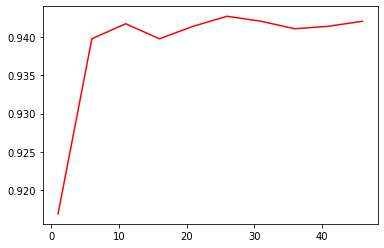

In [57]:
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,50,5):
    rfc = RandomForestClassifier(n_estimators=i+1
                                ,random_state=90)
    score = cross_val_score(rfc,X_train, Y_train, cv=5).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*5+1))

# 绘制学习曲线
x = np.arange(1,51,5)
plt.subplot(111)
plt.plot(x, score_lt, 'r-')
plt.show()

相同处理的数据在不同模型上的效果会有差异，表现较好的为决策树和随机森林，其次为KNN和SVM，其他几个效果较差